# Time Series Forecasting with FLAML Library

## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can

 - serve as an economical AutoML engine,
 - be used as a fast hyperparameter tuning tool, or
 - be embedded in self-tuning software that requires low latency & resource in repetitive tuning tasks.
 - In this notebook, we demonstrate how to use FLAML library to tune hyperparameters of XGBoost with a regression example.

FLAML requires Python>=3.6. To run this notebook example, please install flaml with the notebook option:


In [ ]:
!pip install flaml[notebook,forecast]

## 2. Forecast Problem

### Load data and preprocess

Import co2 data from statsmodel. The dataset is from “Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.,” which collected CO2 samples from March 1958 to December 2001. The task is to predict monthly CO2 samples.

In [1]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas()
data = data.data
# data is given in weeks, but the task is to predict monthly, so use monthly averages instead
data = data['co2'].resample('MS').mean()
data = data.fillna(data.bfill())  # makes sure there are no missing values
data = data.to_frame().reset_index()
# data = data.rename(columns={'index': 'ds', 'co2': 'y'})

In [2]:
# split the data into a train dataframe and X_test and y_test dataframes, where the number of samples for test is equal to
# the number of periods the user wants to predict
num_samples = data.shape[0]
time_horizon = 12
split_idx = num_samples - time_horizon
X_train = data[:split_idx]  # X_train is a dataframe with two columns: time and value
X_test = data[split_idx:]['index'].to_frame()  # X_test is a dataframe with dates for prediction
y_test = data[split_idx:]['co2']  # y_test is a series of the values corresponding to the dates for prediction

### Run FLAML

In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them.

In [3]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [4]:
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'mape',  # primary metric for validation: 'mape' is generally used for forecast tasks
    "task": 'forecast',  # task type
    "log_file_name": 'CO2_forecast.log',  # flaml log file
    "eval_method": "holdout", # validation method can be chosen from ['auto', 'holdout', 'cv']
    # "estimator_list": ["sarimax"],
    # "verbose": 3,
    "split_type": 'time'  # for foretask task, 'split_type' has to be 'time'
}

In [5]:
'''The main flaml automl API'''
automl.fit(dataframe=X_train,  # training data
           label=('index', 'co2'),  # For 'forecast' task, label should be a tuple of strings for timestamp and value columns
           **settings, 
           period=time_horizon,  # key word argument 'period' must be included for forecast task
           freq='M')

[flaml.automl: 08-23 15:56:25] {1219} INFO - Evaluation method: holdout
[flaml.automl: 08-23 15:56:25] {691} INFO - Using TimeSeriesSplit
[flaml.automl: 08-23 15:56:25] {1250} INFO - Minimizing error metric: mape
[flaml.automl: 08-23 15:56:25] {1274} INFO - List of ML learners in AutoML Run: ['fbprophet', 'arima', 'sarimax']
[flaml.automl: 08-23 15:56:25] {1457} INFO - iteration 0, current learner fbprophet
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[flaml.automl: 08-23 15:56:30] {1614} INFO -  at 4.7s,	best fbprophet's error=0.0007,	best fbprophet's error=0.0007
INFO:flaml.automl: at 4.7s,	best fbprophet's error=0.0007,	best fbprophet's error=0.0007
[flaml.automl: 08-23 15:56:30] {1457} INFO - iteration 1, current learner fbprophet
INFO:flaml.automl:iteration 1, current learner fbprophet
INFO:prophet:Disabling weekly seasonality

### Best model and metric

In [6]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print(f'Best mape on validation data: {automl.best_loss}')
print(f'Training duration of best run: {automl.best_config_train_time}s')

Best ML leaner: fbprophet
Best hyperparmeter config: {'changepoint_prior_scale': 0.03498447027670827, 'seasonality_prior_scale': 2.616244037716704, 'holidays_prior_scale': 5.713876592939503, 'seasonality_mode': 'additive'}
Best mape on validation data: 0.00047658614467724217
Training duration of best run: 1.8398802280426025s


In [7]:
print(automl.model.estimator)

In [8]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [9]:
''' compute predictions of testing dataset '''
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

Predicted labels 0     370.443113
1     371.170226
2     372.222488
3     373.412902
4     373.907859
5     373.399315
6     372.046066
7     370.141179
8     368.558253
9     368.637791
10    369.854576
11    371.126664
Name: yhat, dtype: float64
True labels 514    370.175
515    371.325
516    372.060
517    372.775
518    373.800
519    373.060
520    371.300
521    369.425
522    367.880
523    368.050
524    369.375
525    371.020
Name: co2, dtype: float64


In [10]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('mape', '=', sklearn_metric_loss_score('mape', y_pred, y_test))

mape = 0.0011218052996337928


### Log history

In [11]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=300)

for config in config_history:
    print(config)

{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameters': {'changepoint_prior_scale': 0.010000000000000002, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, 'Best Learner': 'fbprophet', 'Best Hyper-parameters': {'changepoint_prior_scale': 0.010000000000000002, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}}
{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameters': {'changepoint_prior_scale': 0.0091602623296037, 'seasonality_prior_scale': 0.8823866403788657, 'holidays_prior_scale': 3.2294014074557995, 'seasonality_mode': 'additive'}, 'Best Learner': 'fbprophet', 'Best Hyper-parameters': {'changepoint_prior_scale': 0.0091602623296037, 'seasonality_prior_scale': 0.8823866403788657, 'holidays_prior_scale': 3.2294014074557995, 'seasonality_mode': 'additive'}}
{'Current Learner': 'fbprophet', 'Current Sample': 502, 'Current Hyper-parameter

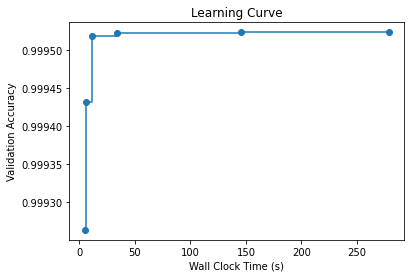

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()